**Báo cáo cuối kỳ môn học: PYTHON CHO KHOA HỌC DỮ LIỆU**

**Lớp 23TTH, Khoa Toán - Tin học, Trường Đại học Khoa học Tự nhiên, ĐHQG-HCM**

**Đề tài thực hiện:**
$$
\text{\textbf{USING DEEP LEARNING TO CLASSIFY ANIMAL AND HUMAN IMAGES}}
$$

**Giảng viên hướng dẫn: ThS. Hà Văn Thảo**

**Danh sách thành viên nhóm:**

1. 23110114 - Nguyễn Thị Hồng Thắm \
2. 23110123 - Lê Huỳnh Yến Vy \
3. 23110132 - Trần Nhật Anh

# GIỚI THIỆU

Object detection là một trong những chủ đề "nóng" trong deep learing bởi tính ứng dụng cao trong thực tiễn và nguồn dữ liệu dồi dào, dễ chuẩn bị. Một trong những thuật toán object detection nổi tiếng nhất là **YOLO**.

YOLO là mô hình mạng neuron tích chập (CNN) được sử dụng phổ biển để nhận dạng các đối tượng trong ảnh hoặc video. Điểm đặc biệt của mô hình này là có khả năng phát hiện tất cả các đối tượng trong một hình ảnh chỉ qua một lần lan truyền của CNN.

Các phương pháp truyền thống tách biệt bước đề xuất vùng và bước phân loại, YOLO xử lý toàn bộ hình ảnh trong một lần lan truyền duy nhất qua mạng CNN. Cơ chế này cho phép mô hình vừa định vị (localization), vừa phân loại (classification) đối tượng cùng lúc.

YOLO có nghĩa là "You only look once", thuật toán chỉ cần "nhìn" một lần để có thể đưa ra dự đoán, giúp đạt được tốc độ xử lý cực nhanh, tiệm cận thời gian thực (real-time) mà vẫn đảm bảo độ chính xác cao. Vì vậy, YOLO được ứng dụng rộng rãi trong đa dạng lĩnh vực: từ quản lý giao thông thông minh, giám sát dây chuyền sản xuất, nông nghiệp công nghệ cao (đếm vật nuôi,...), cho đến các hệ thống an ninh giám sát (phát hiện vũ khí, chấm công tự động,...),...

# TẠO MÔI TRƯỜNG ẢO VÀ KERNEL CHẠY NOTEBOOK (LINUX)

Dự án Python cần **môi trường ảo (virtual environment)** để tự cách ly, tránh xung đột phiên bản thư viện giữa các dự án. `venv` là môi trường ảo mà chúng ta sẽ sử dụng trong dự án này. Sau khi cài đặt `venv`, chúng ta di chuyển đường dẫn đến folder chứa dự án trong terminal và sử dụng lệnh sau để cài đặt môi trường ảo cho dự án:

`python -m venv .venv`

Trong đó, `.venv` là tên của folder chứa môi trường ảo của dự án, đồng thời nó cũng sẽ "đóng băng" phiên bản Python, pip và các thư viện sẽ được dùng trong dự án.

Kích hoạt môi trường ảo:

`source .venv/bin/activate`

Lúc này, phiên bản Python và `pip` được dùng là của môi trường ảo, các thư viện cài bằng `pip install` cũng chỉ ảnh hưởng trong `.venv`. Cách nhận biết đang ở môi trường ảo là promt terminal thường đổi thành `(.venv) user_name@machine:~` (nếu đang sử dụng Linux). Khi đã kích hoạt môi trường ảo, đảm bảo phiên bản Python và `pip` đã "đóng băng" trong đó, sử dụng lệnh:

`which python && which pip`

Nếu output có dạng `.../<project_name>/.venv/...` thì môi trường ảo đã được kích hoạt thành công.

Tiếp theo, tạo một kernel để chạy Jupyter Notebook. Cài đặt `ipykernel` để tạo kernel:

`python -m pip install ipykernel`

Sau khi cài đặt thành công, tiến hành tạo kernel để chạy file `.ipynb`:

`python -m ipykernel install --prefix .venv --name yolovenv --display-name "this_project"`

`--prefix .venv`: kernel mặc định không tự lưu vào `.venv`, thuộc tính này sẽ lưu kernel đã tạo vào `.venv`  
`--name yolovenv`: tên folder chứa kernel, ở đây tên folder là `yolovenv`. Kernel sẽ được lưu tại `.venv/share/jupyter/kernels/yolovenv/`  
`--display-name "this_project`: kernel sẽ hiển thị dưới tên `this_project` trong VS Code.

Khi đã tạo kernel, click vào biểu tượng kernel ở góc trên bên phải, chọn
$$
\text{Select Another Kernel} \rightarrow \text{Jupyter Kernel...} \rightarrow \text{this\_project}
$$

# CÁC THƯ VIỆN CẦN DÙNG

In [1]:
from collections import Counter
import cv2
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
from pathlib import Path
import random
import seaborn as sns
from ultralytics import YOLO

# CHUẨN BỊ VÀ TỔNG QUAN VỀ DỮ LIỆU

## CHUẨN BỊ DỮ LIỆU

Dữ liệu được tải về tại các nguồn sau: \
- https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset \
- https://www.kaggle.com/datasets/biancaferreira/african-wildlife \
- https://www.kaggle.com/datasets/wutheringwang/dog-face-detectionyolo-format \
- https://www.kaggle.com/datasets/samuelayman/cat-dataset \
- https://universe.roboflow.com/labo-yolo/age-and-gender-xlnfj/dataset/3

Dữ liệu sau khi được tải về sẽ được xử lý (gán lại class ID; phân loại thành các folder train, valid, test;...), sau đó được gộp thành một folder tập dữ liệu (dataset) duy nhất. Dataset nếu muốn được YOLO "hiểu" thì phải có file `.yaml` chứa các thông tin về dataset như vị trí của file train, valid, test; số class; tên của các class ứng với mỗi class_id;...

Dataset của dự án này nằm tại `dataset/complete_dataset`, bao gồm: \
- folder `images` chứa các file ảnh, được chia thành ba folder train, valid, test. \
- folder `labels` chứa các file **nhãn dữ liệu (label)** có đuôi `.txt`, cũng được chia thành ba folder train, valid, test và các file label có tên ứng với các file ảnh. \
- file `.yaml` để cung cấp thông tin về dataset cho YOLO.

In [2]:
DATASET_PATH = "dataset/complete_dataset/data.yaml"

## LÀM SẠCH VÀ CHUẨN HOÁ DỮ LIỆU

Dữ liệu hình ảnh được tổng hợp từ nhiều nguồn khác nhau thường tìm ẩn các vấn đề về tính toàn vẹn, chẳng hạn như sự không đồng nhất về định dạng (PNG, JPG, WEBP...), lỗi header của file ảnh hoặc file bị hỏng hoàn toàn (corrupt). Những vấn đề này có thể gây ra lỗi ngắt quãng (crash) đột ngột cho thư viện huấn luyện (như PyTorch/YOLO) khi mô hình cố gắng đọc dữ liệu, làm gián đoạn quá trình huấn luyện kéo dài.

Để khắc phục, cần làm sạch và chuẩn hóa dataset thông qua hàm `resave_images` để:
- Chuẩn hóa định dạng: Mở từng file ảnh, chuyển đổi hệ màu về RGB và lưu lại (re-save) dưới định dạng JPEG để đảm bảo tính nhất quán. \
- Xử lý lỗi tự động: Nếu phát hiện file ảnh bị lỗi không thể đọc được (corrupt), tự động xóa file ảnh đó, đồng thời xóa luôn file nhãn (label) tương ứng để tránh dư thừa label. \
- Tối ưu hóa quy trình: Để tránh việc phải xử lý lại toàn bộ dữ liệu (tốn nhiều thời gian) mỗi khi chạy lại file Jupyter Notebook, cần tạo một cơ chế đánh dấu bằng việc kiểm tra liệu có tồn tại file `flag_file.txt` trong folder chứa dataset. Quá trình chuẩn hóa chỉ được thực hiện nếu file này chưa tồn tại.

Kiểm tra xem dataset đã từng được xử lý chưa thông qua hàm `check_flag_file`.

In [3]:
def check_flag_file(BASE_DIR):
    flag_file = BASE_DIR / "flag_file.txt"

    if not flag_file.exists():
        return False
    
    with open(flag_file, 'r') as file:
        return file.read().strip() == "This dataset has been re-saved already."

Hàm tạo flag file `create_flag_file`.

In [4]:
def create_flag_file(BASE_DIR):
    if check_flag_file(BASE_DIR):
        return
    
    flag_file = BASE_DIR / "flag_file.txt"
    content = "This dataset has been re-saved already."

    with open(flag_file, 'w') as file:
        file.write(content)

Thực hiện chuẩn hóa và loại bỏ ảnh lỗi. Hàm `resave` sẽ duyệt qua toàn bộ thư mục, thực hiện việc xác thực (verify) và lưu lại ảnh. Những ảnh bị lỗi Exception sẽ bị xóa cùng với file label của chúng.

In [5]:
def resave(IMAGES_DIR, LABELS_DIR):
    fixed = 0
    removed = 0

    for root, _, files in os.walk(IMAGES_DIR):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                continue

            # Ghép IMAGES_DIR với tên file ảnh thành path file ảnh
            image_path = os.path.join(root, file)

            try:
                # Mở ảnh để verify nhanh, nếu ảnh có vấn đề -> exception
                with Image.open(image_path) as image:
                    image.verify()

                # Mở lại để re-save
                with Image.open(image_path) as image:
                    image = image.convert("RGB")
                    image.save(image_path, "JPEG", quality=95, subsampling=0)

                fixed += 1

            except Exception:
                # Nếu ảnh hỏng -> xoá file ảnh cùng với file label tương ứng
                os.remove(image_path)
                removed += 1

                relative_path = os.path.relpath(root, IMAGES_DIR)

                label_path = os.path.join(
                    LABELS_DIR,
                    relative_path,
                    os.path.splitext(file)[0] + ".txt"
                )

                if os.path.exists(label_path):
                    os.remove(label_path)

    return fixed, removed

Hàm `resave_images` điều phối quá trình và thông báo số lượng ảnh đã sửa hoặc đã xóa.

In [6]:
def resave_images(BASE_DIR, IMAGES_DIR, LABELS_DIR):
    if check_flag_file(BASE_DIR):
        return 0, 0
    else:
        fixed, removed = resave(IMAGES_DIR, LABELS_DIR)
        create_flag_file(BASE_DIR)

        return fixed, removed

In [7]:
BASE_DIR = Path("dataset/complete_dataset")
IMAGES_DIR = "dataset/complete_dataset/images"
LABELS_DIR = "dataset/complete_dataset/labels"

fixed, removed = resave_images(BASE_DIR, IMAGES_DIR, LABELS_DIR)

print("Fixed  :", fixed)
print("Removed:", removed)

Fixed  : 0
Removed: 0


## KIỂM TRA FILE LABEL TƯƠNG ỨNG VỚI FILE ẢNH

Sau khi hoàn tất xử lý dataset, dùng hàm `count_missing` để kiểm tra xem với mỗi file ảnh thì có file label tương ứng hay không. Cần đảm bảo 100% ảnh đầu vào đều có nhãn tương ứng (0% missing labels).

Sau bước làm sạch và chuẩn hoá dataset, tiến hành kiểm tra tính toàn vẹn của dữ liệu thông qua hàm `count_missing`. Mục tiêu của bước này là rà soát đối sánh từng file ảnh với file label tương ứng trong các thư mục con (train, valid, test) để đảm bảo rằng mọi dữ liệu đưa vào mô hình đều hợp lệ và đầy đủ thông tin.

Hàm `count_missing` được xây dựng để duyệt qua từng file ảnh và kiểm tra sự tồn tại của file label `.txt` tương ứng. Cần đảm bảo toàn bộ ảnh đều có file label (0% missing labels).

In [8]:
def count_missing(BASE_DIR, image_exts, sub_folder):
    images_dir = BASE_DIR / "images" / sub_folder
    labels_dir = BASE_DIR / "labels" / sub_folder

    images_cnt = 0
    missing_cnt = 0

    for image in images_dir.iterdir():
        if image.suffix.lower() not in image_exts:
            continue

        images_cnt += 1
        """
        image.stem dùng để lấy tên của file image mà không có phần mở rộng
        Ví dụ: example123.png -> example123
        """
        label_file = labels_dir / f"{image.stem}.txt"
        if not label_file.exists():
            missing_cnt += 1

    return images_cnt, missing_cnt

Tiến hành chạy kiểm tra trên toàn bộ dataset và tổng hợp kết quả vào bảng để dễ dàng quan sát tỷ lệ lỗi.

In [9]:
BASE_DIR = Path("dataset/complete_dataset")
image_exts = {".jpg", ".jpeg", ".png", ".webp"}
sub_folders = ["train", "valid", "test"]

print(f"Checking dataset: {str(BASE_DIR)}\n")

total_images = 0
total_missing = 0
images_cnt_arr = np.array([])
missing_cnt_arr = np.array([])
missing_percent_arr = np.array([])

for sub_folder in sub_folders:
    images_cnt, missing_cnt = count_missing(BASE_DIR, image_exts, sub_folder)
    total_images += images_cnt
    total_missing += missing_cnt

    missing_percent = (missing_cnt / images_cnt) * 100 if images_cnt > 0 else 0

    images_cnt_arr = np.append(images_cnt_arr, images_cnt)
    missing_cnt_arr = np.append(missing_cnt_arr, missing_cnt)
    missing_percent_arr = np.append(missing_percent_arr, missing_percent)

images_percent = np.array([(images_cnt / total_images) * 100 \
                           for images_cnt in images_cnt_arr])

np_table = np.array([images_cnt_arr, images_percent, \
                     missing_cnt_arr, missing_percent_arr])
table = pd.DataFrame(np_table).transpose()
table.columns = ["images", "images/total (%)", "missing_labels", "missing_labels (%)"]
table.index = ["train", "valid", "test"]
table['images'] = table['images'].astype(int)
table['missing_labels'] = table['missing_labels'].astype(int)

missing_percent = (total_missing / total_images) * 100 \
    if total_images > 0 else 0

print(table)
print("")
print(f"-> Total images:       {total_images}")
print(f"-> Total missing:      {total_missing}")
print(f"-> Total missing (%):  {missing_percent}")

Checking dataset: dataset/complete_dataset

       images  images/total (%)  missing_labels  missing_labels (%)
train   20451         65.619585               0                 0.0
valid    6078         19.502021               0                 0.0
test     4637         14.878393               0                 0.0

-> Total images:       31166
-> Total missing:      0
-> Total missing (%):  0.0


Kết quả cho thấy toàn bộ 31166 ảnh đều có đủ file label tương ứng (`Total missing: 0`), dữ liệu đảm bảo điều kiện để huấn luyện mô hình.

## PHÂN BỐ CÁC CLASS

Việc này nhằm xác định mức độ mất cân bằng dữ liệu giữa 85 class của dataset, nhận diện lớp chiếm ưu thế và các lớp thiểu số hoặc các lớp rỗng để lường trước những nhược điểm, hạn chế của mô hình.

In [10]:
CLASS_NUM = 85

Ngoài ra cũng có thể có nhiều object trong mỗi ảnh nên tổng số object luôn nhiều hơn hoặc bằng số ảnh. Cụ thể, dataset này có tổng cộng 36243 object so với 31166 ảnh.

In [11]:
LABELS_DIR = BASE_DIR / "labels"

counter = Counter()

for label_file in LABELS_DIR.rglob("*.txt"):
    with open(label_file, "r") as file:
        for line in file:
            if line.strip():
                class_id = int(line.split()[0])
                counter[class_id] += 1

df = pd.DataFrame(
    sorted(counter.items()),
    columns=["class_id", "object_count"]
)

df = df.sort_values("object_count", ascending=False, ignore_index=True)
total_objects = df["object_count"].sum()
df["object_count (%)"] = (df["object_count"] * 100 / total_objects).round(5)
print(f"Total objects: {total_objects}")

Total objects: 36243


Có 85 class nhưng bảng `df` chỉ có 79 dòng, nghĩa là có 6 class không có object.

In [12]:
df

,class_id,object_count,object_count (%)
0,83,6340,17.49303
1,3,2774,7.65389
2,17,1647,4.54433
3,48,1603,4.42292
4,36,1246,3.43791
...,...,...,...
74,24,33,0.09105
75,75,26,0.07174
76,67,16,0.04415
77,1,8,0.02207


Các `class_id` không có object nào là 25, 40, 50, 54, 57, 58.

In [13]:
all_classes = set(range(CLASS_NUM))
found_classes = set(counter.keys())

missing_classes = sorted(all_classes - found_classes)
print("Missing class_ids:", missing_classes)
print("Number of missing classes:", len(missing_classes))

Missing class_ids: [25, 40, 50, 54, 57, 58]
Number of missing classes: 6


In [14]:
# Sắp xếp df theo thứ tự giảm dần của cột object_count rồi lấy 15 dòng đầu tiên
df_top15 = df.sort_values(by="object_count", 
                          ascending=False, 
                          ignore_index=True).head(15)

df_top15

,class_id,object_count,object_count (%)
0,83,6340,17.49303
1,3,2774,7.65389
2,17,1647,4.54433
3,48,1603,4.42292
4,36,1246,3.43791
5,84,1188,3.27787
6,79,1021,2.81710
7,66,915,2.52463
8,16,913,2.51911
9,14,864,2.38391


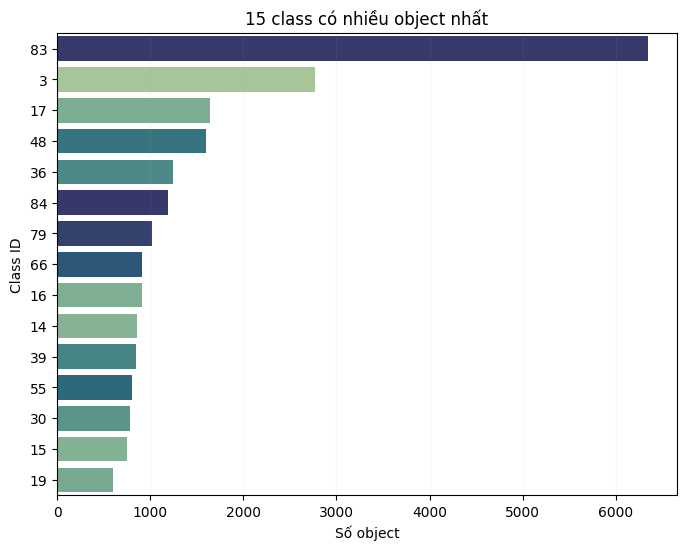

In [15]:
plt.figure(figsize=(8, 6))

order = (
    df_top15
    .sort_values("object_count", ascending=False)["class_id"]
    .astype(str)
)

sns.barplot(
    data=df_top15,
    x="object_count",
    y=df_top15["class_id"].astype(str),
    order=order,
    hue="class_id",
    palette="crest",
    legend=False,
    errorbar=None
)

plt.xlabel("Số object")
plt.ylabel("Class ID")
plt.title("15 class có nhiều object nhất")
plt.grid(axis='x', alpha=0.1)
plt.show()


In [16]:
# Sắp xếp df theo thứ tự tăng dần của cột object_count rồi lấy 15 dòng đầu tiên
df_bottom15 = df.sort_values(by="object_count", 
                             ascending=True, 
                             ignore_index=True).head(15)

df_bottom15

,class_id,object_count,object_count (%)
0,59,7,0.01931
1,1,8,0.02207
2,67,16,0.04415
3,75,26,0.07174
4,24,33,0.09105
5,2,39,0.10761
6,62,40,0.11037
7,32,57,0.15727
8,29,61,0.16831
9,38,67,0.18486


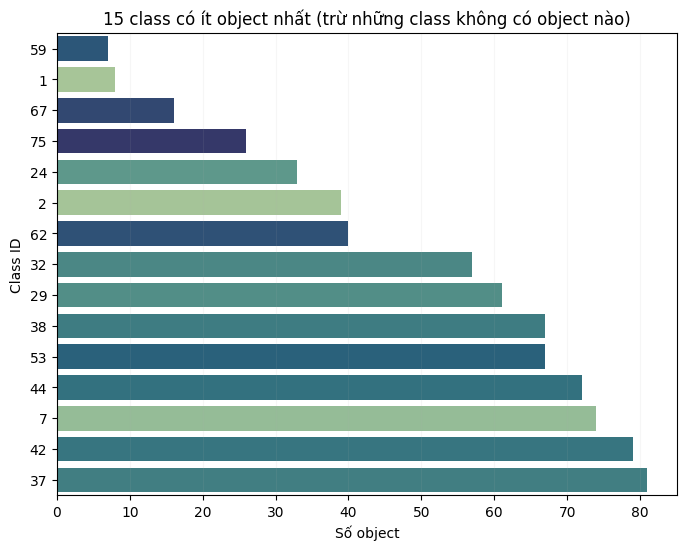

In [17]:
plt.figure(figsize=(8, 6))

order = (
    df_bottom15
    .sort_values("object_count", ascending=True)["class_id"]
    .astype(str)
)

sns.barplot(
    data=df_bottom15,
    x="object_count",
    y=df_bottom15["class_id"].astype(str),
    order=order,
    hue="class_id",
    palette="crest",
    legend=False,
    errorbar=None
)

plt.xlabel("Số object")
plt.ylabel("Class ID")
plt.title("15 class có ít object nhất (trừ những class không có object nào)")
plt.grid(axis='x', alpha=0.1)
plt.show()


Phân bố số lượng đối tượng (object) giữa các class là không đồng đều. Quan sát hai biểu đồ trên, có thể thấy sự mất cân bằng nghiêm trọng giữa các class. Cụ thể:
- Class có ID 83 chiếm số lượng áp đảo với 6340 object (khoảng 17.5%), gấp hơn 2 lần so với class đứng thứ hai  là 3 (2774 đối tượng, chiếm khoảng 7.65%).
- Ngược lại, có những lớp có dữ liệu cực ít như class 59 (7 đối tượng), class 1 (8 đối tượng). Thậm chí, có 6 class (25, 40, 50, 54, 57, 58) hoàn toàn không có object nào.

Điều này sẽ khiến mô hình có xu hướng học thiên lệch (bias), nhận diện tốt các class có nhiều object nhưng dễ bỏ qua các class chiếm thiểu số, `recall` thấp cho các class thiểu số, `precision` (độ chính xác) có vẻ cao nhưng `mAP` giữa các class không đồng đều,...

## PHÂN BỐ KÍCH THƯỚC ẢNH

In [18]:
# Chỉ cần kiểm tra phân bố kích thước ảnh của file train
IMAGE_DIR = Path("dataset/complete_dataset/images/train")

widths = np.array([])
heights = np.array([])

image_paths = [
    p for p in IMAGE_DIR.iterdir()
    if p.suffix.lower() in {".jpg", ".png", ".jpeg", ".webp"}
]

for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is None:
        continue

    height, width, _ = image.shape
    widths = np.append(widths, width)
    heights = np.append(heights, height)

Biểu đồ phân bố kích thước ảnh.

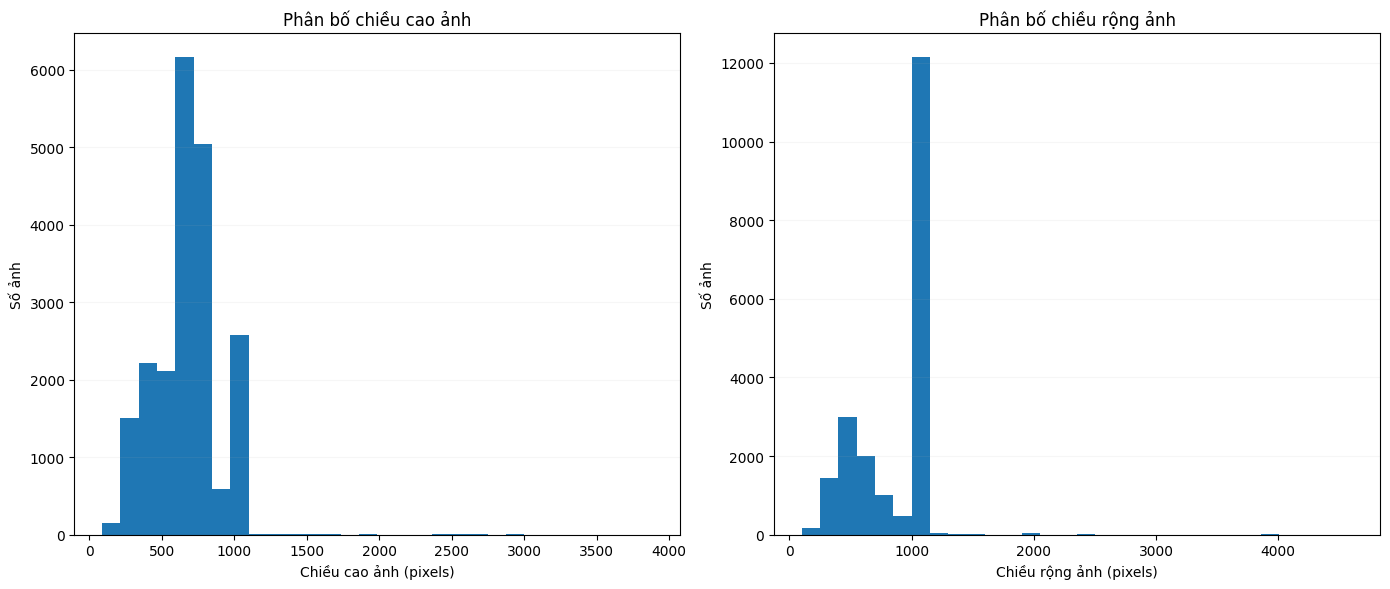

In [34]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30)
plt.xlabel("Chiều cao ảnh (pixels)")
plt.ylabel("Số ảnh")
plt.title("Phân bố chiều cao ảnh")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30)
plt.xlabel("Chiều rộng ảnh (pixels)")
plt.ylabel("Số ảnh")
plt.title("Phân bố chiều rộng ảnh")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

plt.show()

Biểu đồ trên cho thấy dữ liệu bao gồm nhiều ảnh với độ phân giải khác nhau, kích thước từ nhỏ đến lớn. Do đó, nên so sánh mô hình với các `imgsz` khác nhau. Với ảnh có kích thước nhỏ thì `imgmz` cao sẽ hiệu quả hơn trong việc huấn luyện mô hình, nhưng đổi lại là thời gian và tài nguyên tính toán.

Dựa trên biểu đồ phân bố chiều rộng và chiều cao ảnh thực tế, đề tài xác định cần thử nghiệm các `imgsz` khác nhau (`448px` và `640px`) để tìm điểm cân bằng giữa việc giữ lại chi tiết ảnh và tốc độ xử lý.

# KHAI BÁO, HUẤN LUYỆN VÀ LƯU MÔ HÌNH

Phiên bản các thư viện dùng để huấn luyện mô hình: \
- Ultralytics 8.3.243 \
- Python-3.12.8 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX A6000, 48541MiB)

Mô hình sẽ được huấn luyện với hai hàm `train_model_with_SGD` và `train_model_with_AdamW`. Hàm `train_model_with_AdamW` có thêm các tham số tối ưu hoá, huấn luyện mô hình để cho ra các kết quả dùng để so sánh ở các phần sau.

Optimizer mặc định của YOLO11s/YOLO11m là `SGD`, mô hình sẽ được huấn luyện để so sánh với optimizer `AdamW`.

In [20]:
def train_model_with_SGD(model, epochs, imgsz, dataset_path, project_path, 
                         project_name):
    model.train(
        exist_ok=True,
        data=dataset_path,
        project=project_path,
        name=project_name,

        epochs=epochs,
        imgsz=imgsz,
        batch=32,
        workers=12,
        seed=42,
        device=0,  # sử dụng GPU

        cos_lr=True,

        mosaic=0.1,
        mixup=0.0,
        copy_paste=0.0,

        optimizer="SGD",
        lr0=0.01,
        momentum=0.937,
        weight_decay=5e-4,
    )


def train_model_with_AdamW(model, epochs, imgsz, dataset_path, project_path, 
                           project_name):
    model.train(
        exist_ok=True,
        data=dataset_path,
        project=project_path,
        name=project_name,

        epochs=epochs,
        imgsz=imgsz,
        batch=32,
        workers=12,
        seed=42,
        device=0,  # sử dụng GPU

        cos_lr=True,

        mosaic=0.1,
        mixup=0.0,
        copy_paste=0.0,

        optimizer="AdamW",
        lr0=0.001,
        weight_decay=1e-2,
    )

Thay vì chọn một cấu hình ngẫu nhiên, đề tài áp dụng phương pháp tìm kiếm lưới để xác định kiến trúc tối ưu nhất:
- So sánh kiến trúc mạng: Đánh giá hiệu năng giữa YOLO11s (Small - tối ưu tốc độ) và YOLO11m (Medium - cân bằng độ chính xác).
- Khảo sát siêu tham số: huấn luyện 16 mô hình với 16 tổ hợp tham số: số vòng lặp (`epochs`); kích thước ảnh (image size - `imgsz`); thuật toán tối ưu (`optimizer`): So sánh giữa `SGD` (truyền thống) và `AdamW` (hiện đại) xem thuật toán nào hội tụ, cho ra kết quả tốt hơn.

In [21]:
BASE_MODELS = ["yolo11s", "yolo11m"]

epochs_list = [30, 80]
imgsz_list = [448, 640]
optimizer_list = ["SGD", "AdamW"]

# Huấn luyện mô hình với các thông số khác nhau
parameters = list(product(epochs_list, imgsz_list, optimizer_list))

Huấn luyện mô hình với các tham số khác nhau dựa trên YOLO11s và YOLO11m.

In [22]:
for base_model in BASE_MODELS:
    for parameter in parameters:
        epochs, imgsz, optimizer = parameter

        # Lưu model tại "runs/{...}/epochs{...}_imgsz{...}_{...}" sau khi train
        best_path = (
            Path(f"runs/{base_model}")
            / f"epochs{epochs}_imgsz{imgsz}_{optimizer}"
            / "weights"
            / "best.pt"
        )
        model_path = f"runs/{base_model}"
        model_name = f"epochs{epochs}_imgsz{imgsz}_{optimizer}"

        # Huấn luyện mô hình với dataset
        if best_path.exists():
            print(str(best_path))
            print(f"Model has been trained already. It is being loaded again...")
            model = YOLO(str(best_path))
        else:
            print(str(best_path))
            print("Model hasn't been trained. Start training...")

            # Huấn luyện mô hình dựa trên mô hình gốc
            model = YOLO(base_model)
            if optimizer == "AdamW":
                train_model_with_AdamW(
                    model=model,
                    epochs=epochs,
                    imgsz=imgsz,
                    dataset_path=DATASET_PATH,
                    project_path=model_path,
                    project_name=model_name
                )
            else:
                train_model_with_SGD(
                    model=model,
                    epochs=epochs,
                    imgsz=imgsz,
                    dataset_path=DATASET_PATH,
                    project_path=model_path,
                    project_name=model_name
                )

            # Load lại best.pt sau khi train, nếu không tìm thấy thì in ra lỗi
            assert best_path.exists(), "Training finished but file best.pt not found"
            model = YOLO(str(best_path))

            print("Training finished")

runs/yolo11s/epochs30_imgsz448_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz448_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz640_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz640_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz448_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz448_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz640_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz640_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11m/epochs30_imgsz448_SGD/weights/best.pt
Model has been trained already. It is being loaded ag

# KẾT QUẢ SAU HUẤN LUYỆN

Tổng hợp kết quả từ 16 tổ hợp tham số vào bảng dữ liệu thống nhất, dựa trên các chỉ số `mAP50`, `mAP50-95`, `precision` và `recall` để chọn ra bộ trọng số (`best.pt`) tốt nhất.

In [23]:
# Hàm ghép dòng vào dataframe
def df_concat(last_results, best_results, base_model, parameter):
    epochs, imgsz, optimizer = parameter

    row = pd.DataFrame([{
        "model": base_model,
        "optimizer": optimizer,
        "epochs": int(epochs),
        "best_epoch": int(best_results["epoch"].iloc[0]),
        "imgsz": int(imgsz),
        "mAP50": float(best_results["metrics/mAP50(B)"].iloc[0]),
        "mAP50-95": float(best_results["metrics/mAP50-95(B)"].iloc[0]),
        "precision": float(best_results["metrics/precision(B)"].iloc[0]),
        "recall": float(best_results["metrics/recall(B)"].iloc[0])
    }])

    last_results = pd.concat([last_results, row], ignore_index=True)

    return last_results

In [24]:
printed_results_columns = [
    "epoch",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/precision(B)",
    "metrics/recall(B)"
]
df_columns = {
    "model": "string",
    "optimizer": "string",
    "epochs": "int64",
    "best_epoch": "int64",
    "imgsz": "int64",
    "mAP50": "float64",
    "mAP50-95": "float64",
    "precision": "float64",
    "recall": "float64",
}
# last_results là tổng hợp 16 best_results của 16 tham số
last_results = pd.DataFrame({
    columns: pd.Series(dtype=dtype) for columns, dtype in df_columns.items()
})

for base_model in BASE_MODELS:
    for parameter in parameters:
        epochs, imgsz, optimizer = parameter

        results_path = (
            Path(f"runs/{base_model}")
            / f"epochs{epochs}_imgsz{imgsz}_{optimizer}"
            / "results.csv"
        )

        results = pd.read_csv(results_path)
        # best_results là dòng trong results.csv có metrics/mAP50-95 cao nhất cột
        total_training_time = results["time"].iloc[0]
        best_results = (
            results.nlargest(1, "metrics/mAP50-95(B)")[printed_results_columns]
        )
        last_results = df_concat(last_results, best_results, base_model, 
                                 parameter)

last_results

,model,optimizer,epochs,best_epoch,imgsz,mAP50,mAP50-95,precision,recall
0,yolo11s,SGD,30,28,448,0.63171,0.52254,0.67112,0.60531
1,yolo11s,AdamW,30,29,448,0.62606,0.51541,0.69223,0.57907
2,yolo11s,SGD,30,30,640,0.64837,0.53774,0.72044,0.60040
3,yolo11s,AdamW,30,27,640,0.65413,0.53899,0.69437,0.61965
4,yolo11s,SGD,80,59,448,0.68338,0.56863,0.70953,0.64419
5,yolo11s,AdamW,80,51,448,0.66939,0.55505,0.71050,0.63714
6,yolo11s,SGD,80,74,640,0.69285,0.58045,0.71261,0.65929
7,yolo11s,AdamW,80,61,640,0.67469,0.56426,0.72661,0.62902
8,yolo11m,SGD,30,30,448,0.62506,0.51984,0.66062,0.61128
9,yolo11m,AdamW,30,30,448,0.58683,0.48617,0.61359,0.56119


# SO SÁNH

## LOSS THEO EPOCHS

In [41]:
def plot_loss_comparison(
    base_model: str,
    epochs: int,
    imgsz: int,
):
    print(f"{base_model} | epochs={epochs} | imgsz={imgsz}")
    
    results_paths = {
        "SGD": Path(f"runs/{base_model}/epochs{epochs}_imgsz{imgsz}_SGD/results.csv"),
        "AdamW": Path(f"runs/{base_model}/epochs{epochs}_imgsz{imgsz}_AdamW/results.csv"),
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    loss_types = ["box", "cls"]

    for optimizer, results_path in results_paths.items():
        if not results_path.exists():
            print(f"{results_path} not found")
            continue

        df = pd.read_csv(results_path)

        for ax, loss_type in zip(axes, loss_types):
            loss_col = f"train/{loss_type}_loss"
            ax.plot(
                df["epoch"],
                df[loss_col],
                label=optimizer
            )
            ax.set_title(f"Chỉ số {loss_type}_loss theo từng epoch")
            ax.set_xlabel("epoch")
            ax.set_ylabel(f"{loss_type}_loss")
            ax.grid(True)

    for index in range(2):
        axes[index].legend()

    plt.tight_layout()
    plt.show()

yolo11s | epochs=30 | imgsz=448


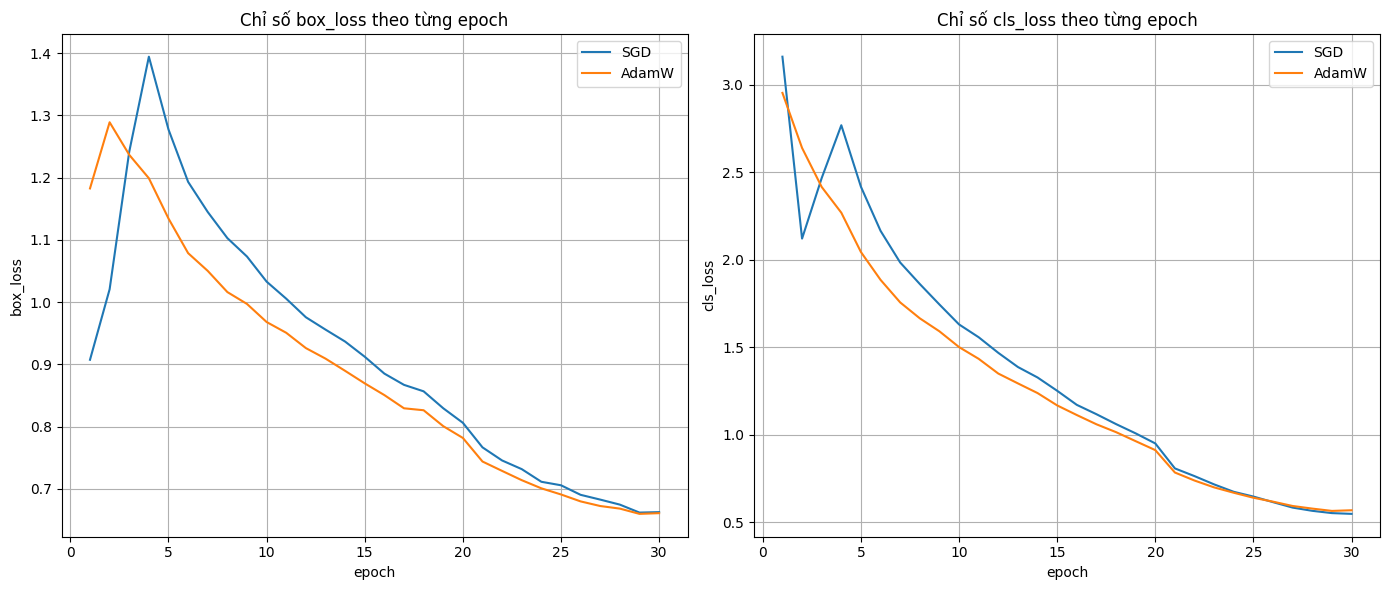

yolo11s | epochs=30 | imgsz=640


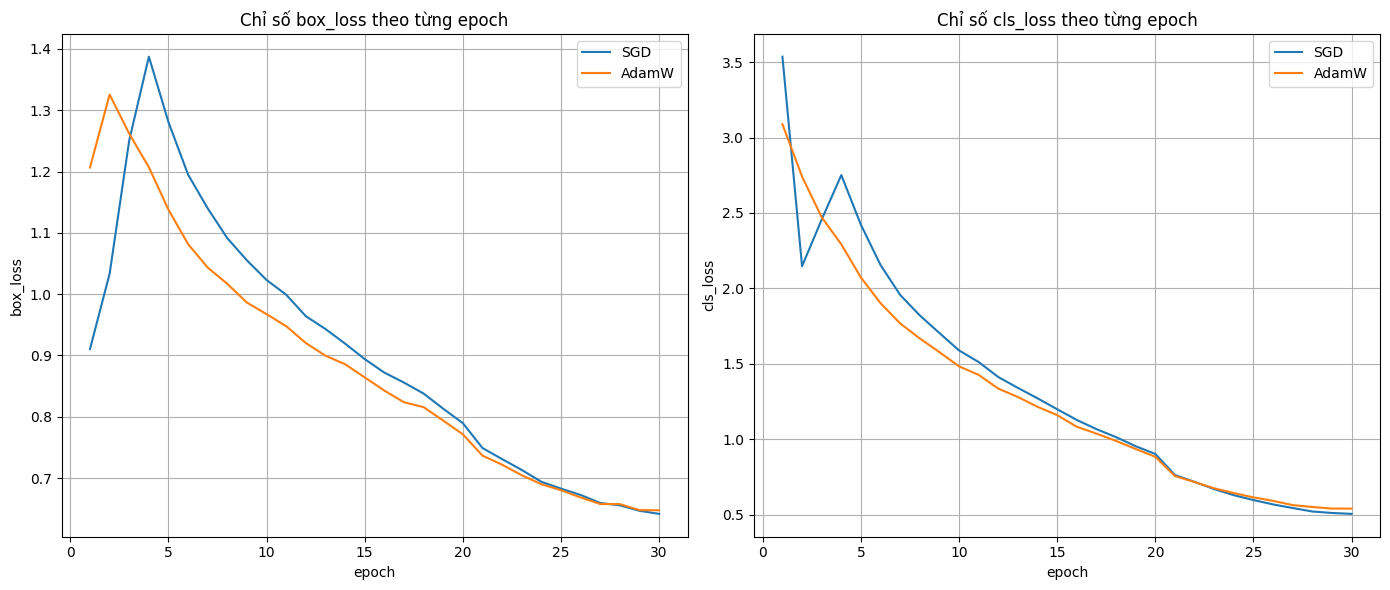

yolo11s | epochs=80 | imgsz=448


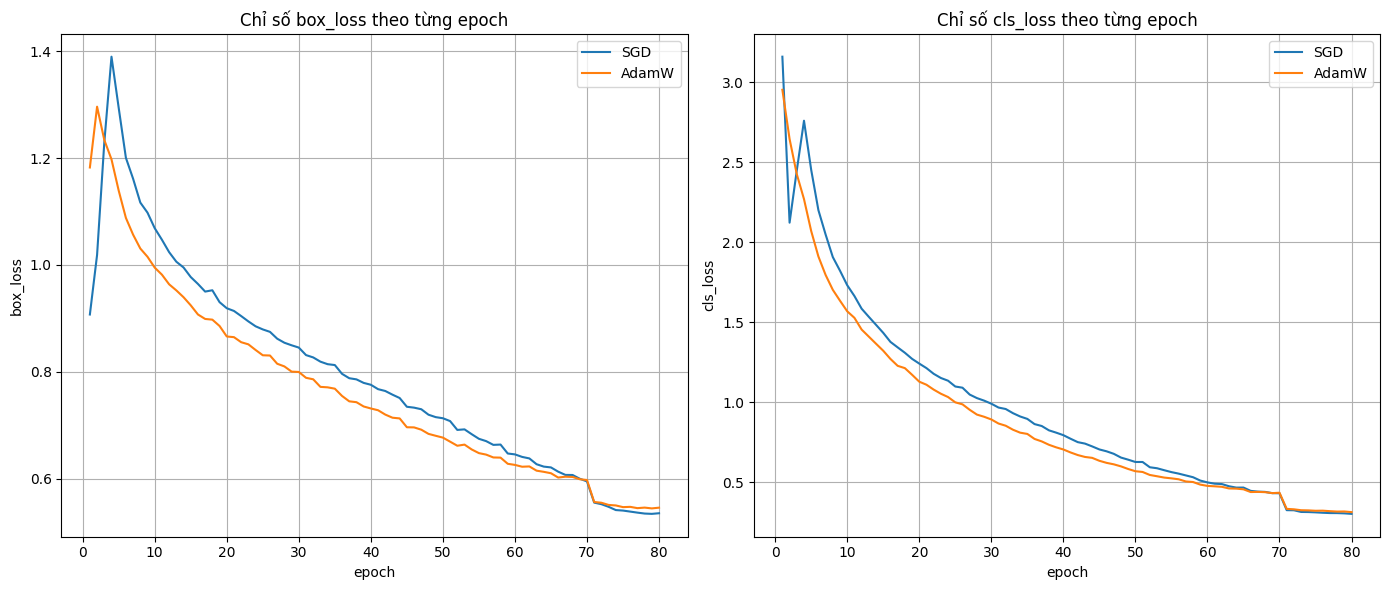

yolo11s | epochs=80 | imgsz=640


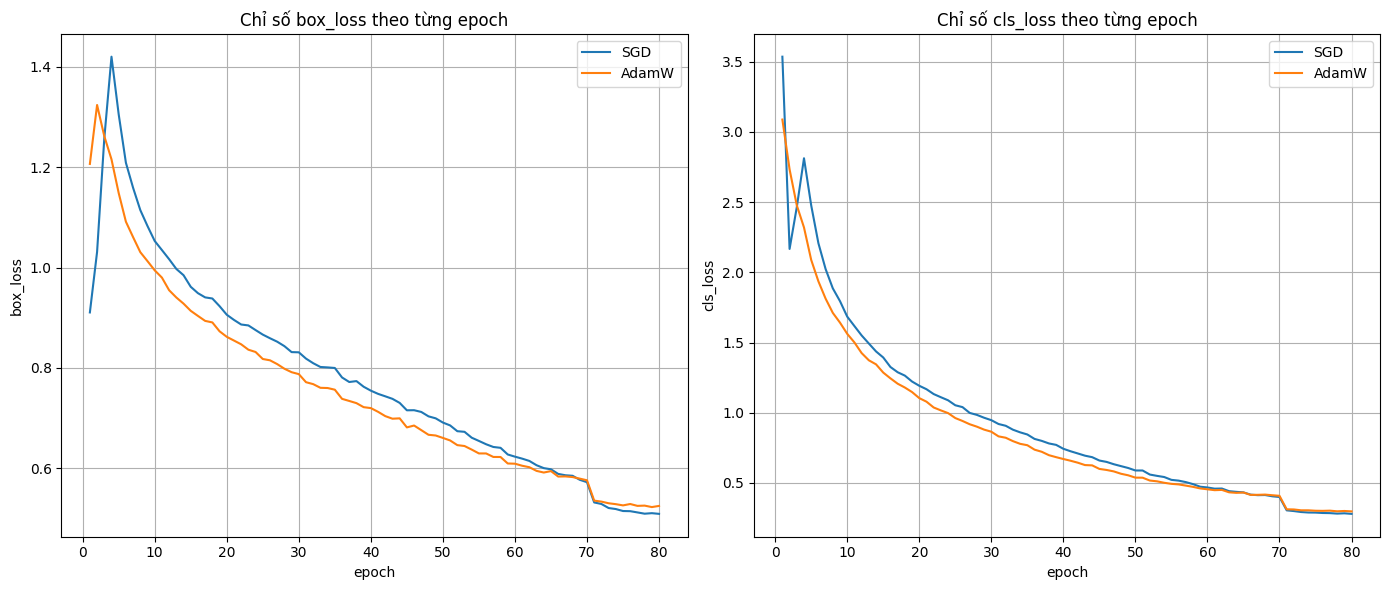

yolo11m | epochs=30 | imgsz=448


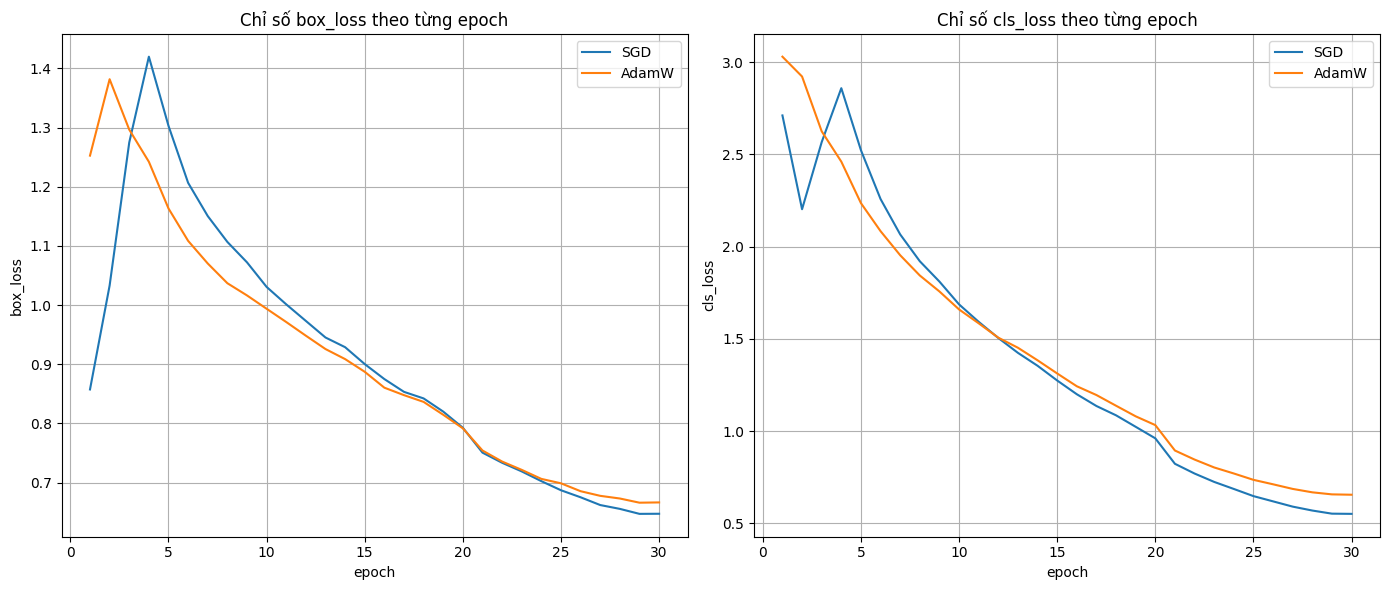

yolo11m | epochs=30 | imgsz=640


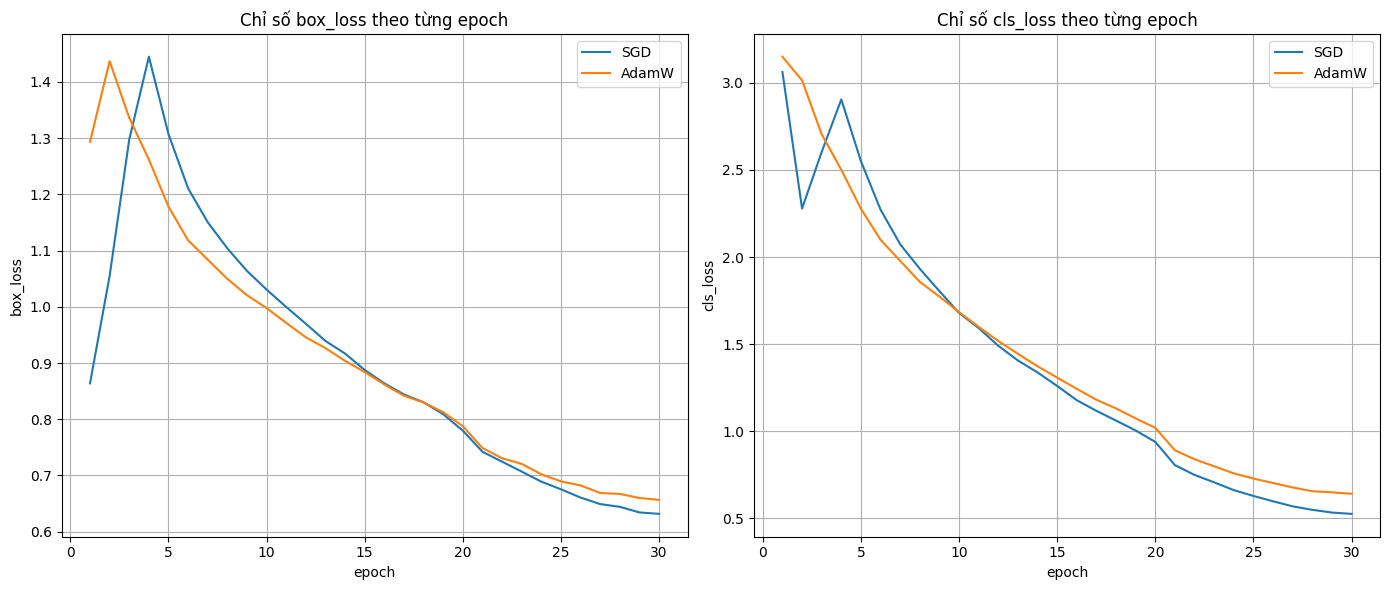

yolo11m | epochs=80 | imgsz=448


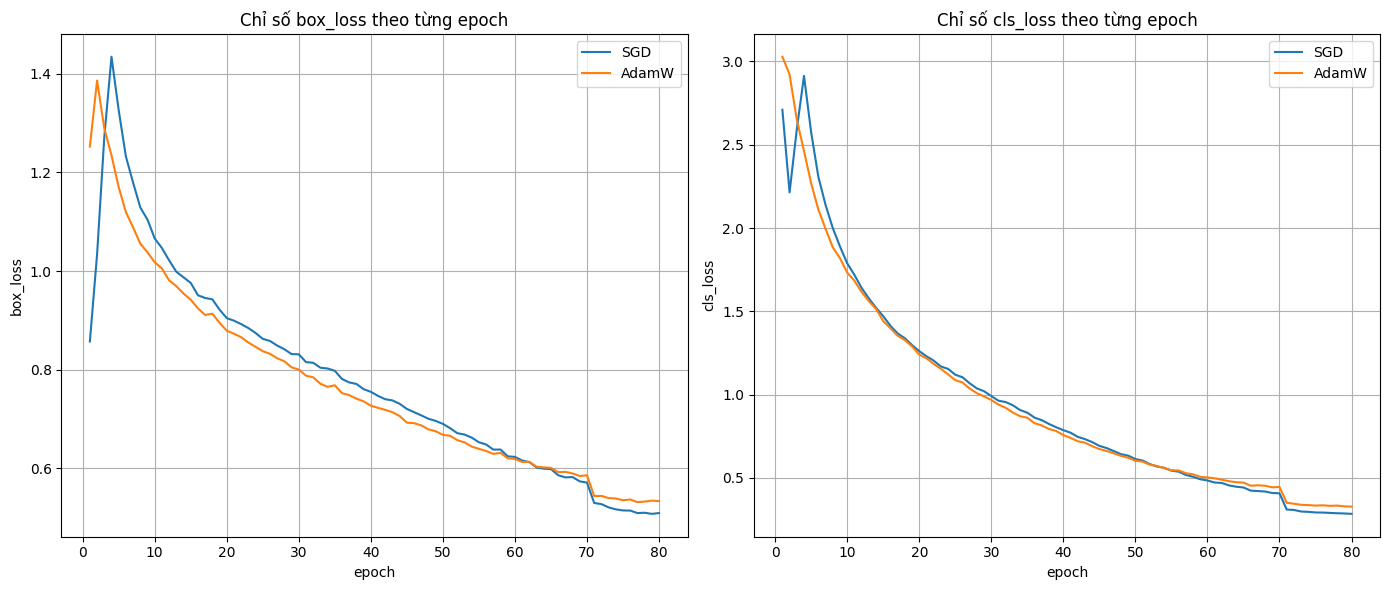

yolo11m | epochs=80 | imgsz=640


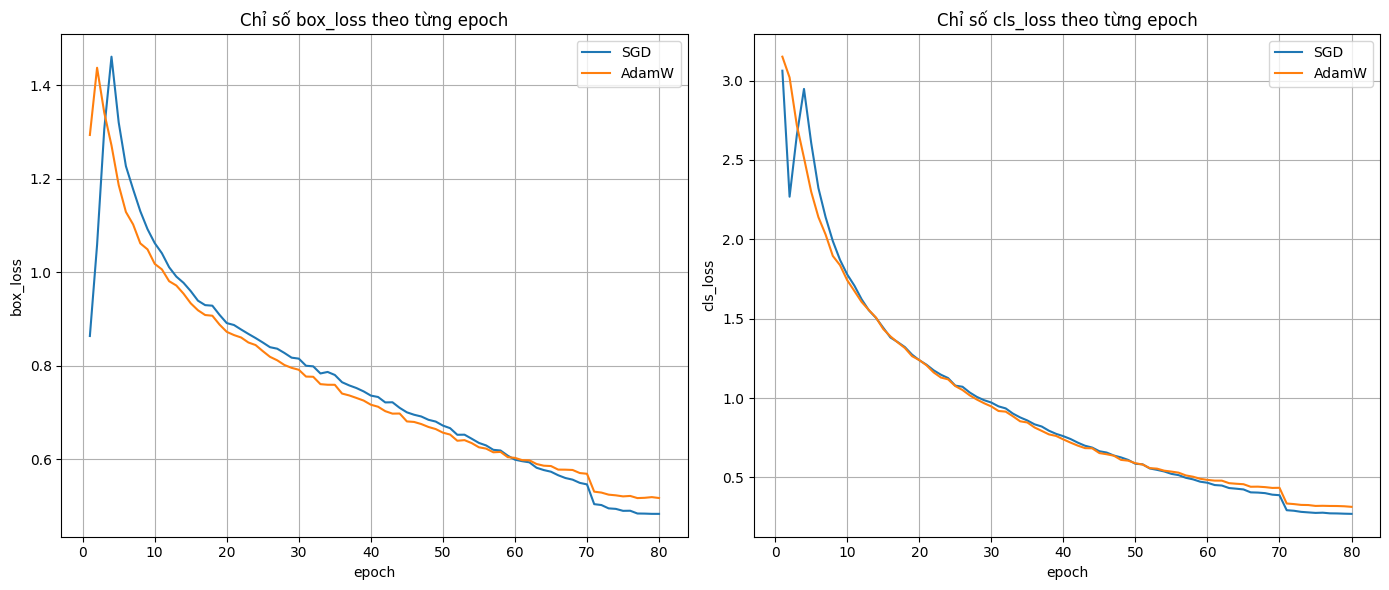

In [42]:
for base_model in BASE_MODELS:
    for epochs in epochs_list:
        for imgsz in imgsz_list:
            plot_loss_comparison(
                base_model=base_model,
                epochs=epochs,
                imgsz=imgsz
            )